In [ ]:
pip install accelerate -U

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
#4.2 다중 언어 트랜스포머
from transformers import AutoTokenizer

xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import pipeline

model_id = "allspace/xlm-roberta-base-finetuned-panx-de"
classifier = pipeline("token-classification", model=model_id, device=device)

In [ ]:
## 헬퍼 함수 : 모델의 예측결과를 token과 tag의 데이터프레임으로 보여줌
import pandas as pd

def tag_text(text, tags, model, tokenizer):
  tokens = tokenizer(text).tokens()
  input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
  outputs = model(input_ids)[0]
  predictions = torch.argmax(outputs, dim=2)
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=['Token', 'Tags'])

In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, classifier.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Token,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [ ]:
## 데이터셋 준비
from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
#키가 없는 경우 DatseDict를 반환한다
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  ds = load_dataset('xtreme', name=f"PAN-X.{lang}")
  for split in ds:
    panx_ch[lang][split] = (
        ds[split].shuffle(seed=0)
        .select(range(int(frac * ds[split].num_rows)))
    )

tags = panx_ch['de']['train'].features['ner_tags'].feature
index2tag = {idx:tag for idx, tag in enumerate(tags.names)}
tag2index = {tag:idx for idx, tag in enumerate(tags.names)}

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation=True,\
                                   is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples['ner_tags']):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx == None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx

    labels.append(label_ids)
  tokenized_inputs['labels'] = labels
  return tokenized_inputs


def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,\
                    remove_columns=['langs', 'ner_tags', 'tokens'])

panx_de_encoded = encode_panx_dataset(panx_ch['de'])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

In [ ]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=3e9d7362e7b6d4b54331ed0ab18a029172754f4948ee33d05a3cf7cca4fbbca4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,\
                                     eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

In [ ]:
from torch.nn.functional import cross_entropy
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

def forward_pass_with_label(batch):
  #리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환합니다.
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  #입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
  batch = data_collator(features)
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  labels = batch['labels'].to(device)
  with torch.no_grad():
    #데이터를 모델에 전달합니다
    output = classifier.model(input_ids, attention_mask)
    #logit.size: [batch, sequence_length, label_classes]
    #마지막축을 따라 가장 큰 로짓 값을 가진 클래스를 선택
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  #배치 차원을 펼친 다음 토큰마다 손실을 계산
  loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
  #배치 차원을 다시 만들고 넘파이 배열로 변환
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss":loss, 'predicted_label':predicted_label}

In [ ]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.014135358, 0.0, 0.014407065, 0.0167063...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00022313489, 0.0, 0.0, 0.0, 0.0, 0.555...","[5, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00016604476, 0.000112646434, 0.0001524...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.0003129946, 0.00018976319, 0.000177367...","[5, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.000113242415, 0.000113719194, 0.000130...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [ ]:
index2tag[-100] = "IGN"
df['input_tokens'] = df['input_ids'].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df['predicted_label'] = df['predicted_label'].apply(
    lambda x: [index2tag[i] for i in x ])
df['labels'] = df['labels'].apply(
    lambda x : [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [ ]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.014135358, 0.0, 0.014407065, 0.0167063...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00022313489, 0.0, 0.0, 0.0, 0.0, 0.555...","[B-LOC, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.00016604476, 0.000112646434, 0.0001524...","[O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O]","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.0003129946, 0.00018976319, 0.000177367...","[B-LOC, O, O, O, B-LOC, B-LOC, O, O, O]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 0.000113242415, 0.000113719194, 0.000130...","[O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.02,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.56,B-ORG,▁Luz
1,10,1,I-ORG,0.37,I-ORG,▁a


In [ ]:
(
    df_tokens.groupby('input_tokens')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,1388,989,808,163,1171,246,246,2898,125
mean,0.03,0.09,0.13,0.13,0.58,0.08,0.33,0.31,0.02,0.51
sum,198.19,125.55,124.62,105.09,94.72,88.1,81.65,75.11,68.1,63.71


In [ ]:
(
    df_tokens.groupby('labels')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by='mean', ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.62,0.61,0.49,0.31,0.27,0.19,0.03
sum,910.36,1647.51,1857.64,983.85,788.8,787.14,1226.39


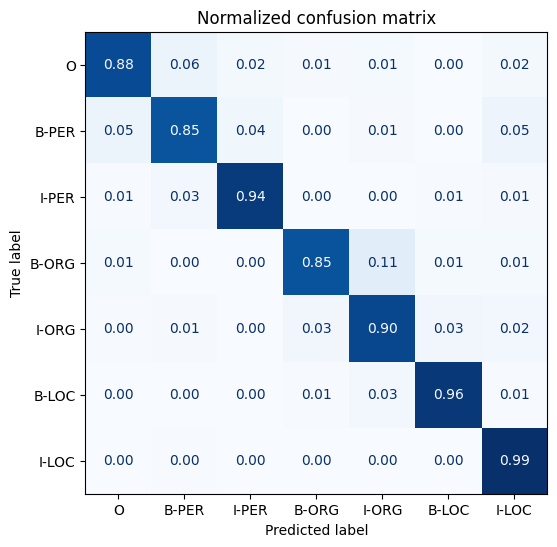

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], tags.names)

In [ ]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention_mask"]):
      if i not in {0, len(row["attention_mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row['input_tokens'][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens":tokens, "labels":labels,\
                           "preds":preds, 'losses':losses}).T
    yield df_tmp
df['total_loss'] = df['loss'].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,2.64,0.00,0.00,0.00,10.36,9.46,8.79,7.68,8.04,0.00,8.55,8.88,0.00,8.69,8.78,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.12,0.00,0.00,5.97,8.06,8.41,5.71,0.00,7.46,8.85,6.93,6.03,4.54,0.00,0.00,0.02,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.93,5.40,5.81,0.00,5.87,0.00,5.54,0.00,4.94,5.50,5.61,5.71,5.44,5.29,0.00


In [ ]:
df_tmp = df.loc[df['input_tokens'].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.02,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,B-LOC
losses,0.02,0.00,0.00,0.02,0.02,0.00,0.02,0.00
